In [1]:
# BEFORE STARTING...
# ==================

%matplotlib notebook

# IMPORT REQUIRED LIBRARIES
import numpy as np
import sympy as sp
import scipy as sc
from scipy import optimize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from IPython.core.display import HTML

# Analysis developed in the UCR flume regarding wave generation

Dimensions of the chanel are defeined as: ${L_x}_{flume}$, ${L_y}_{flume}$ and ${L_z}_{flume}$.

The position of the paddle with respect to the channel is denoted by $x_{paddle}$.

Water height will be dentoted as: $h$

The parameters describing the wave are the following:
+ $H$: wave height ($H = 2 a$)
+ $\lambda$: wave lenght
+ $k$: wave number. ($k = \frac{2 \pi}{\lambda}$)
+ $T$: Wave period
+ $\omega$: wave frequency. ($\omega = \frac{2 \pi}{T}$)

Note that the wave can be addimentionalized considering the following dimensionless variables:

+ $\tilde{\omega} = \omega \sqrt{\frac{h}{g}}$

+ $\tilde{k} = kh$


In [3]:
# INITIALIZE PARAMETERS
# =====================

#---------------------------------------------------------------------  
# Note:
# -----
# This parameters affect the whole notebook
# Introduce known parameters and leave unknowns as "None"
# Parameters with * are compulsory
# Parameters affect the whole code. Tune them:


rho = 1003 #Water density [kg/m^3] *
g = 9.81 #Gravity acceleration [m/s^2] *

Lz_flume = 0.5 #Flume height [m] *
Ly_flume = 0.3 #Flume width [m] *
Lx_flume = 10 #Flume lengHt [m] *

x_paddle = 0 #Paddle home position [m] *

wavemaker_type = 'piston' #Wavemaker 'piston' or 'flap' type
Smax = 400 #Wavemaker stroke (just to check between limits)

h = 0.4 #Water height [m]

H = 0.1 #Wave height[m]
a = None #Wave semi-height [m]

lamda = None #Wave lenght [m]
k = None #Wave number [rad/m] 

T = 1.5 #Wave period [s]
omega = None #wave frequency [rad/s]

psi = 0 #Wave phase shift [rad]

S = None #Stroke of the moving paddle 
#---------------------------------------------------------------------

# Define the 2D basin
Lx = Lx_flume - x_paddle

X = np.linspace(0,Lx,100)
Z = np.linspace(-h,0,10)

XX, ZZ = np.meshgrid(X, Z)

## 2D Linear wave problem

As a general rule of thumb, for wave height to wavelength ratios less than 1/7 we can linearize:
$$ \frac{H}{\lambda} < \frac{1}{7} $$

### Problem definition

The linear free surface wave problem is goberned by Laplace equation and the linearized boundary conditions:
..................................................................

### Problem solution 

The solution to the problem is the following:

$$\eta(x,t) = a \cos(kx - \omega t + \psi)$$

$$\phi(x,z,t) = -\frac{a \omega}{k} f(z) \sin(kx - \omega t + \psi)$$

$$u(x,z,t) = a \omega f(z) \cos(kx - \omega t + \psi)$$

$$w(x,z,t) = -a \omega f_1(z) \sin(kx - \omega t + \psi)$$

$$f(z) = \frac{\cosh(k(z+h))}{\sinh(k h)}$$

$$f_1(z) = \frac{\sinh(k(z+h))}{\sinh(k h)}$$

The **dispersion relationship** is also obtained as part of the solution of the linear wave problem and relates uniquely $\omega$, $k$ and $h$.

$$\omega^2 = g k \tanh(k h)$$

It is commonly presented in addimentional manner using the Froude number ($Fr$):

$$(\tilde{\omega} -\tilde{k} Fr)^2 = \tilde{k} \tanh(\tilde{k})$$

+ Approximation for **shallow water**: as $kh \rightarrow 0$, $\tanh(kh) \rightarrow kh$:

$$\omega^2 \approx g k^2 h$$

+ Approximation for **deep water**: as $kh \rightarrow \infty$, $\tanh(kh) \rightarrow 1$:

$$\omega^2 \approx g k$$

### Pressure under the wave

THe pressure under the wave is obtained from unsteady Bernouilli's equation:

$$p = -\rho \frac{\partial \phi}{\partial t} - \frac{1}{2} \rho V^2 - \rho g z$$

For a linearizer problem, second order tems can be neglected and the dynamic pressure can be computed as:

$$P_d(x,z,t) = - \rho \frac{\partial \phi}{\partial t} = \rho g \eta(x,t) \frac{\cosh(k(z+h))}{\cosh(kh)}$$ 

In [4]:
# FUNCTIONS TO OBTAIN THE SOLUTIONS TO THE LINEAR WAVE PROBLEM
# ============================================================

# eta(x,t)
def eta_lin(x,t):
    return a*np.cos(k*x-omega*t+psi)

# phi(x,z,t)
def phi_lin(x,z,t):
    return a*omega/k*f_lin(z)*np.sin(k*x-omega*t+psi)

# u(x,z,t)
def u_lin(x,z,t):
    return a*omega*f_lin(z)*np.cos(k*x-omega*t+psi)

# w(x,z,t)
def w_lin(x,z,t):
    return a*omega*f1_lin(z)*np.sin(k*x-omega*t+psi)

# f(x,z,t)
def f_lin(z):
    return np.cosh(k*(z+h))/np.sinh(k*h)

# f1(x,z,t)
def f1_lin(z):
    return np.sinh(k*(z+h))/np.sinh(k*h)

# Function to obtain omega from h and k by dispersion relation
def dispersion_omega(h,k):
    return np.sqrt(g*k*np.tanh(k*h))

# Function to obtain k from omega and k by dispersion relation
def dispersion_h(omega,k):
    return np.arctanh((omega**2)/(g*k))/k

# Function to obtain k from h and omega by dispersion relation
def dispersion_k(h,omega):
    def equation(k):
        return g*k*np.tanh(k*h)-(omega**2)
    return sc.optimize.fsolve(equation,1)[0]

# Function to compute the parameters of the linear free surface wave problem
def compute_parameters(h = None, H = None, a = None, lamda = None,
                       k = None, T = None, omega = None, psi = 0, print_results = False):
    OK = True
    
    #Converting inputs into floats
    try: h = float(h)
    except: pass
    try: H = float(H)
    except: pass
    try: a = float(a)
    except: pass
    try: lamda = float(lamda)
    except: pass
    try: k = float(k)
    except: pass
    try: T = float(T)
    except: pass
    try: omega = float(omega)
    except: pass
    try: psi = float(psi)
    except: pass
    
    #CHecking/computing wave height
    if isinstance(H,float) and a==None:
        a = H/2
    elif isinstance(a,float) and H==None:
        H = 2*a
    elif isinstance(H,float) and isinstance(a,float):
        if not np.isclose(H,2*a):
            OK = False
            if print_results:
                print('ERROR: H is not 2*a')
    else:
        OK = False
        if print_results:
            print('ERROR: Wave height (H or a) not defined')
    
    #CHecking/computing wave length/number
    if isinstance(lamda,float) and k==None:
        k = 2*np.pi/lamda
    elif isinstance(k,float) and lamda==None:
        lamda = 2*np.pi/k
        
    #CHecking/computing wave period/frequency
    if isinstance(T,float) and omega==None:
        omega = 2*np.pi/T
    elif isinstance(omega,float) and T==None:
        T = 2*np.pi/omega
        
    #CHecking/computing dispersion
    if isinstance(h,float) and isinstance(k,float) and omega == None:
        omega = dispersion_omega(h,k)
        T = 2*np.pi/omega
    elif isinstance(omega,float) and isinstance(k,float) and h == None:
        h = dispersion_h(omega,k)
    elif isinstance(h,float) and isinstance(omega,float) and k == None:
        k = dispersion_k(h,omega)
        lamda = 2*np.pi/k
    elif isinstance(h,float) and isinstance(k,float) and isinstance(omega,float):
        if not np.isclose(omega,dispersion_omega(h,k)):
            OK = False
            if print_results:
                print('ERROR: Parameters do not satisfy Dispersion Relationship')
    else:
        OK = False
        if print_results:
                print('ERROR: Not enough parameters defined')
    
    if OK:
        #Addimensional parameters and Froude number
        omega_adim = omega*np.sqrt(h/g)
        k_adim = k*h
        Fr = (np.sqrt(k*np.tanh(k_adim))-omega_adim)/k_adim 
    
    if print_results:
        #Print parameters
        print('h = '+str(h)+' m')
        print('H = '+str(H)+' m')
        print('a = '+str(a)+' m')
        print('lamda = '+str(lamda)+' m')
        print('k = '+str(k)+' rad/m')
        print('T = '+str(T)+' s')
        print('omega = '+str(omega)+' rad/s')
        print('psi = '+str(psi)+' rad')
        if OK:
            print('Fr = '+str(Fr))
            if H/lamda < (1/7):
                print('H/lamda = '+str(H/lamda)+' < 0.143. OK')
            else:
                print('H/lamda = '+str(H/lamda)+' > 0.143. ¿LINEARITY?' )
        else:
            print('**ERRORS WERE FOUND**')
    
    return h, H, a, lamda, k, T, omega, psi , OK

# P_d(x,z,t): linear dynamic pressure
def Pd_lin(x,z,t):
    return -rho*g*eta_lin(x,t)*np.cosh(k*(z+h))/np.cosh(k*h) # -rho*g*z

h = 0.4 m
H = 0.1 m
a = 0.05 m
lamda = 2.61584218342 m
k = 2.40197415081 rad/m
T = 1.5 s
omega = 4.1887902047863905 rad/s
psi = 0.0 rad
Fr = 0.511606054418
H/lamda = 0.0382286059281 < 0.143. OK


<IPython.core.display.Javascript object>


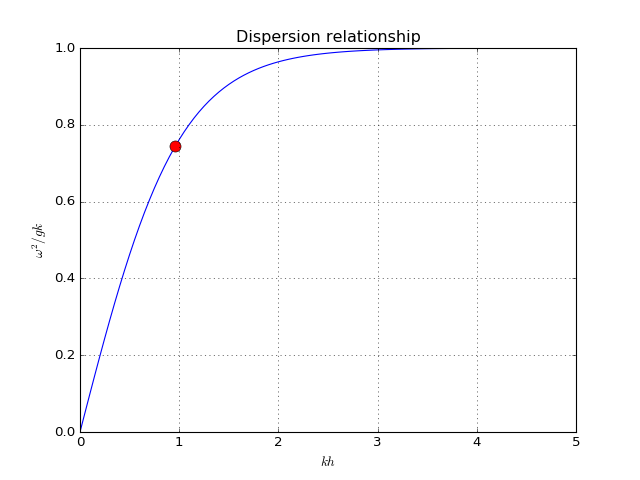

In [5]:
# COMPUTE UNKNOWNS AND CHECK IN THE DISPERSION RELATIONSHIP CURVE
# ===============================================================

# Compute unknowns
h, H, a, lamda, k, T, omega, psi, OK = compute_parameters(h = h, H = H, a = a, lamda = lamda, k = k, T = T, omega = omega, psi = psi, print_results = True)

# Plot dispersion relationship
x = np.arange(0.0, 5, 0.05)
y = np.tanh(x)

fig, ax = plt.subplots()
ax.plot(x,y)
ax.plot(k*h, omega**2/(g*k),marker='o', markersize=10, color="red")
ax.set(xlabel=r'$kh$', ylabel=r'$\omega^2/gk$',
       title='Dispersion relationship')
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


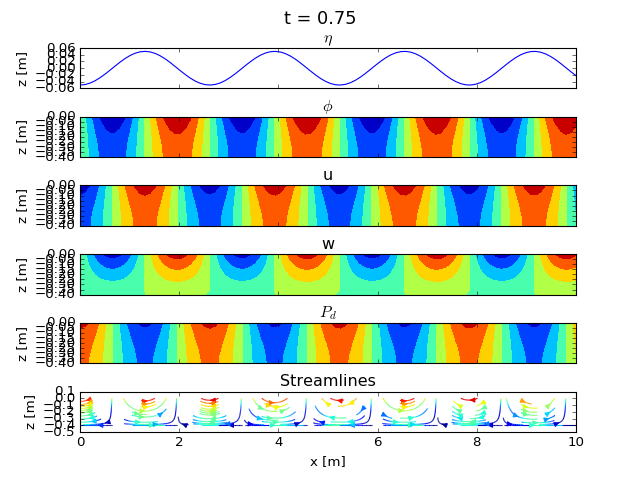

In [6]:
# FREE SURFACE AND FLOW FIELD OF THE LINEAR WAVE
# ==============================================

#---------------------------------------------------------------------  
# Note:
# -----
# Tune plot options:
# choose beteen an animation in time or an specific time 

ANIMATION = False


if ANIMATION:
    time_steps = 20
    anim_loop = False
else:
    t = T/2
#--------------------------------------------------------------------- 

eta = np.zeros((X.size,1))
phi = np.zeros((X.size,Z.size))
u = np.zeros((X.size,Z.size))
w = np.zeros((X.size,Z.size))
Pd = np.zeros((X.size,Z.size))
speed = np.zeros((X.size,Z.size))

fig, ax = plt.subplots(6, sharex=True)

if ANIMATION:
    def animate(t):
        t = T*t/time_steps
        for count_x, x in enumerate(X):
            eta[count_x] = eta_lin(x,t)
            for count_z, z in enumerate(Z):
                phi[count_x][count_z] = phi_lin(x,z,t)
                u[count_x][count_z] = u_lin(x,z,t)
                w[count_x][count_z] = w_lin(x,z,t)
                Pd[count_x][count_z] = Pd_lin(x,z,t)
                speed[count_x][count_z] = u[count_x][count_z]**2 + w[count_x][count_z]**2

        if t is not 0:
            for i in np.arange(0,6,1): ax[i].clear()

        fig.suptitle('t = ' + str(t), fontsize=16)

        cs0 = ax[0].plot(XX[0,:], eta)
        ax[0].set(ylabel='z [m]',title=r'$\eta$', xlim=(0,Lx))
        cs1 = ax[1].contourf(XX, ZZ, phi.transpose())
        ax[1].set(ylabel='z [m]',title=r'$\phi$')
        cs2 = ax[2].contourf(XX, ZZ, u.transpose())
        ax[2].set(ylabel='z [m]',title='u')
        cs3 = ax[3].contourf(XX, ZZ, w.transpose())
        ax[3].set(ylabel='z [m]',title='w')
        cs4 = ax[4].contourf(XX, ZZ, Pd.transpose())
        ax[4].set(ylabel='z [m]',title=r'$P_d$')
        strm = ax[5].streamplot(XX, ZZ, u.transpose(), w.transpose(), color=speed.transpose(), linewidth=1)
        ax[5].set(xlabel='x [m]', ylabel='z [m]',title='Streamlines')
        plt.subplots_adjust(hspace=0.7)
        return ax
    
    ani = FuncAnimation(fig,animate,frames = time_steps,interval=(T/time_steps)*1000, blit=False, repeat = anim_loop)

    plt.show()
    
else:
    for count_x, x in enumerate(X):
        eta[count_x] = eta_lin(x,t)
        for count_z, z in enumerate(Z):
            phi[count_x][count_z] = phi_lin(x,z,t)
            u[count_x][count_z] = u_lin(x,z,t)
            w[count_x][count_z] = w_lin(x,z,t)
            Pd[count_x][count_z] = Pd_lin(x,z,t)
            speed[count_x][count_z] = u[count_x][count_z]**2 + w[count_x][count_z]**2
    fig.suptitle('t = ' + str(t), fontsize=16)
    cs0 = ax[0].plot(XX[0,:], eta)
    ax[0].set(ylabel='z [m]',title=r'$\eta$', xlim=(0,Lx))
    cs1 = ax[1].contourf(XX, ZZ, phi.transpose())
    ax[1].set(ylabel='z [m]',title=r'$\phi$')
    cs2 = ax[2].contourf(XX, ZZ, u.transpose())
    ax[2].set(ylabel='z [m]',title='u')
    cs3 = ax[3].contourf(XX, ZZ, w.transpose())
    ax[3].set(ylabel='z [m]',title='w')
    cs4 = ax[4].contourf(XX, ZZ, Pd.transpose())
    ax[4].set(ylabel='z [m]',title=r'$P_d$')
    strm = ax[5].streamplot(XX, ZZ, u.transpose(), w.transpose(), color=speed.transpose(), linewidth=1)
    ax[5].set(xlabel='x [m]', ylabel='z [m]',title='Streamlines')
    plt.subplots_adjust(hspace=0.7)
    plt.show()

## Laboratory wave generation (Hughes)

### Problem definition

Problem is described in a 2D cartesian coordinate system and goberned by Laplace equation and the correspondin boundary conditions:

#### Laplace equation ($\forall$  $x$, $z$, $t$)

$$\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial z^2} = 0$$

#### Bottom BC (at $z = -h$)

$$\frac{\partial \phi}{\partial z} = 0$$

#### Kinematic Free surface BC (KFSBC) (at $z = \eta$)

$$\frac{\partial \eta}{\partial t} + \frac{\partial \phi}{\partial x} \frac{\partial \eta}{\partial x} - \frac{\partial \phi}{\partial z}= 0$$

#### Dynamic Free surface BC (DFSBC) (at $z = \eta$)

$$\frac{\partial \phi}{\partial t} + 
\frac{1}{2} \left[ 
\left( \frac{\partial \phi}{\partial x} \right)^2 + 
\left( \frac{\partial \phi}{\partial z} \right)^2
\right] + g \eta = 0$$

#### Wave board BC (at $x = X(z,t)$)

Assuming that the board is flat, solid and impermeable. THe fluid velocity normal to the wave board Has the same velocity as the wave board.
$$v_n = \frac{\partial \theta}{\partial t}$$

From geometry:
$$r = \sqrt{(X(z,t))^2 + (l+h+z)^2}= (l+h+z) \sqrt{1+\tan^2(\theta)} = \frac{l+h+z}{\cos^2(\theta)}$$
and
$$v_n = u \cos(\theta) + w \sin(\theta)$$

hence:
$$\frac{l+h+z}{\cos^2(\theta)} \cdot \frac{\partial \theta}{\partial t} = u \cos(\theta) + w \sin(\theta)$$

If small angles are assumed, it can be considered the following approximations:
+ $u \cos(\theta) \approx u$
+ $w \sin(\theta) \approx 0$
+ $\tan^2(\theta) << 1$
+ $\theta \approx \frac{X(z,t)}{l+h+z}$

Noting that $$ X (z,t) = \left( 1 + \frac{z}{h+l} \right) X_0(t) $$

and expresing the velocity in terms of velocity potential, the BC can be specified as:

$$\frac{\partial \phi}{\partial x} = \left( 1 + \frac{z}{h+l}\right)  \frac{\partial X_0(t)}{\partial t} = 0$$

THree different cases regarding motion geometry of the wavemaker paddle will be considered:

+ **Piston type**: wHen $l \rightarrow \infty$
+ **Flap type**: wHen $l = 0$
+ **Combined type**: wHen $l = O(h)$

### Problem solution

Using standarrd perturbation tecHniques, it can be obtained first and second order approximations to the wavemaker problem.

#### First order equations:

+ $\frac{\partial^2 \phi_1}{\partial x^2} + \frac{\partial^2 \phi_1}{\partial z^2} = 0$ in the fluid domain

+ $\frac{\partial \phi_1}{\partial z} = 0$ at ($z=-h$)

+ $\frac{\partial^2 \phi_1}{\partial t^2} + g \frac{\partial \phi_1}{\partial z} = 0$ at ($z=0$)

+ $\frac{\partial \phi_1}{\partial x} = \left( 1+\frac{z}{h+l} \right) \frac{d{X_0}_1}{dt}$ at ($x=0$)

#### Second order equations:

+ $\frac{\partial^2 \phi_2}{\partial x^2} + \frac{\partial^2 \phi_2}{\partial z^2} = 0$ in the fluid domain

+ $\frac{\partial \phi_2}{\partial z} = 0$ at ($z=-h$)

+ $\frac{\partial^2 \phi_2}{\partial t^2} + g \frac{\partial \phi_2}{\partial z} =
- \eta_1 \left( g \frac{\partial^2 \phi_1}{\partial z^2} + \frac{\partial^3 \phi_1}{\partial z \partial t^2} \right)
-2 \left( \frac{\partial \phi_1}{\partial x} \frac{\partial^2 \phi_1}{\partial x \partial t} + \frac{\partial \phi_1}{\partial z} \frac{\partial^2 \phi_1}{\partial z \partial t} \right)$ at ($z=0$)

+ $\frac{\partial \phi_2}{\partial x} = \left( 1+\frac{z}{h+l} \right) \frac{d{X_0}_2}{dt} - {X_0}_1 \left( \left( 1+\frac{z}{h+l} \right) \frac{\partial^2 \phi_1}{\partial x^2} - \frac{1}{l+h} \frac{\partial \phi_1}{\partial z} \right)$ at ($x=0$)



### First order wave generation 

It will be assumed a sinusoidal motion of the board corresponding to

$${X_0}_1 = \frac{S_0}{2} \sin(\sigma t)$$

wHere $S_0$ is the wave board stroke at $z=0$ and $S_0/2$ the stroke amplitude.

Note that 

$$\frac{d {X_0}_1}{dt} = \frac{\sigma S_0}{2} \cos(\sigma t)$$

#### Wave height to stroke ratio

THe **general solution** that relates the wave height, and the stroke ratio is the following:

$$\frac{H}{S_0} = \frac{4 \sinh(kh)}{\sinh(2kh)+2kh} \left( \sinh(kh) + \frac{1-\cosh(kh)}{k(h+l)} \right)$$

+ In the case of a **piston type wavemaker** ($l \rightarrow \infty$), the solution reduces to:

$$\frac{H}{S_0} = \frac{4 \sinh^2(kh)}{\sinh(2kh)+2kh}$$

+ and in the case of a **flap type wavemaker** ($l=0$) to:

$$\frac{H}{S_0} = \frac{4 \sinh(kh)}{\sinh(2kh)+2kh} \left( \sinh(kh) + \frac{1-\cosh(kh)}{kh} \right)$$

In very shallow water: 
+ $\frac{H}{S_0} \approx kh$ for a pyston
+ $\frac{H}{S_0} \approx \frac{kh}{2}$ for a flap

#### Wave board pressure

THe first order pressure distribution is:

$$p(x,z,t) = -\rho \frac{\partial \phi_1}{\partial t} - \rho g z$$

Substituting and evaluating the result at $x=0$, the instantaneous pressure on the wave board can be computed.

$$p_0(z,t) = [\rho \sigma A \cosh(k(h+z))] \cos(\sigma t) +
[\rho \sigma \sum_{n=1}^{\infty} ------------------] \sin(\sigma t) - \rho g z$$

<div class=guide>
### Describing function for the linear wavemaker problem
<div/>

In [7]:
# FUNCTIONS TO OBTAIN THE SOLUTIONS TO THE LINEAR WAVEMAKER PROBLEM
# =================================================================

# First order WM function X_0(t):
def X01(t):
    return S/2*np.sin(sigma*t)

# First order WM function A:
def A():
    if Type is 'piston':
        l = np.inf
    elif Type is 'flap':
        l = 0
    return (2*sigma*S)/(k*(np.sinh(2*k*h)+2*k*h))*(np.sinh(k*h)+(1-np.cosh(k*h))/(k*(h+l)))

# First order WM function C_n(k_n):
def Cn(kn):
    if Type is 'piston':
        l = np.inf
    elif Type is 'flap':
        l = 0
    return (2*sigma*S)/(kn*(np.sin(2*kn*h)+2*kn*h))*(np.sin(kn*h)+(np.cos(kn*h)-1)/(kn*(h+l)))

# Function that returns an array of the first "N" k_n that can be 
# found for a given sigma (global variable)
def Vkn(N=5):
    def equation(kn):
        return g*kn*np.tan(kn*h)+sigma**2
    Vkn=np.zeros(N)
    Ni = 0
    guess = 0
    while Ni < N:
        guess = guess + 0.5
        kn2 = sc.optimize.fsolve(equation,guess)[0]
        if Ni == 0:
            if kn2 > 0.2:
                Vkn[Ni] = kn2
                Ni=Ni+1
        else:
            if kn2 > 0.2 and not np.isclose(kn2,Vkn[Ni-1],atol=0.1):
                Vkn[Ni] = kn2
                Ni=Ni+1
    return Vkn

# First order WM function C_n(k_n):
def phi1(x,z,t):
    fkn = 0
    for kn in Vkn():
        fkn = fkn + np.cos(sigma*t)*Cn(kn)*np.exp(-kn*x)*np.cos(kn*(z+h))
    return A()*np.cosh(k*(h+z))*np.sin(k*x-sigma*t) + fkn

# First order WM function eta1(x,t)
def eta1(x,t):
    fkn = 0
    for kn in Vkn():
        fkn = fkn + np.sin(sigma*t)*sigma*Cn(kn)/g*np.exp(-kn*x)*np.cos(kn*h)
    return sigma*A()/g*np.cosh(k*h)*np.cos(k*x-sigma*t) + fkn

# First order WM function eta1(x,t) withot considering near paddle effects
def eta1_far(x,t):
    return sigma*A()/g*np.cosh(k*h)*np.cos(k*x-sigma*t)

# Function to compute the parameters of the first order WM problem
def compute_wavemaker_parameters(Type, S = None, h = None, H = None, a = None, lamda = None,
                       k = None, T = None, omega = None, psi = 0, print_results = False):
    
    OK = True
    
    #Converting inputs into floats
    try: S = float(S)
    except: pass
    
    if Type is 'piston':
            l = np.inf
    elif Type is 'flap':
            l = 0
    else:
        OK = False
        if print_results:
            print('ERROR: Type is not valid', 'warning')
        
    if OK:
        h, H, a, lamda, k, T, omega, psi, OK1 = compute_parameters(h=h, H=H, a=a, lamda=lamda, k=k, T=T, omega=omega, psi=psi)
        if OK1:
            S = H/((4*np.sinh(k*h))/(np.sinh(2*k*h)+2*k*h)*(np.sinh(k*h) + (1-np.cosh(k*h))/(k*(h+l))))
        else:
            if isinstance(S,float) and isinstance(h,float) and isinstance(k,float) and H == None:
                H = S*((4*np.sinh(k*h))/(np.sinh(2*k*h)+2*k*h)*(np.sinh(k*h) + (1-np.cosh(k*h))/(k*(h+l))))
            elif isinstance(H/S,float):
                def equation(kh):
                    return (4*np.sinh(kh))/(np.sinh(2*kh)+2*kh)*(np.sinh(kh) + (1-np.cosh(kh))/(kh+l))
                kh = sc.optimize.fsolve(equation,1)[0]
                
                if isinstance(k,float) and h == None:
                    h = kh/k
                elif isinstance(h,float) and k == None:
                    k = kh/h
                else:
                    OK = False
                    if print_results:
                        print('ERROR: Not enough parameters', 'warning')
            if OK: 
                h, H, a, lamda, k, T, omega, psi, OK1 = compute_parameters(h=h, H=H, a=a, lamda=lamda, k=k, T=T, omega=omega, psi=psi) 
                   
        #Addimensional parameters and Froude number
        if OK:
            omega_adim = omega*np.sqrt(h/g)
            k_adim = k*h
            Fr = (np.sqrt(k*np.tanh(k_adim))-omega_adim)/k_adim 
                   
        if print_results:
            #Print parameters
            print('Wavemaker Type: '+Type)
            print('S = '+str(S)+' m')
            print('h = '+str(h)+' m')
            print('H = '+str(H)+' m')
            print('a = '+str(a)+' m')
            print('lamda = '+str(lamda)+' m')
            print('k = '+str(k)+' rad/m')
            print('T = '+str(T)+' s')
            print('omega = '+str(omega)+' rad/s')
            print('psi = '+str(psi)+' rad')
            if OK:
                print('Fr = '+str(Fr))
                if H/lamda < (1/7):
                    print('H/lamda = '+str(H/lamda)+' < 0.143. OK')
                else:
                    print('H/lamda = '+str(H/lamda)+' > 0.143. ¿LINEARITY?' , 'warning')
                if S/Smax < 1:
                    print( 'S < Smax. OK')
                else:
                    print('S < Smax. Greater KM max. stroke required' , 'warning')
            else:
                print('**ERRORS WERE FOUND**', 'warning')
    
    
    return Type, S, h, H, a, lamda, k, T, omega, psi, OK



<div class=guide>
### Computing unknowns and checking position in the 2D wave height to stroke ratio solution
<div/>

Wavemaker Type: piston
S = 0.105748082922 m
h = 0.4 m
H = 0.1 m
a = 0.05 m
lamda = 2.615842183418294 m
k = 2.401974150813996 rad/m
T = 1.5 s
omega = 4.1887902047863905 rad/s
psi = 0.0 rad
Fr = 0.511606054418
H/lamda = 0.03822860592810052 < 0.143. OK
S < Smax. OK


<IPython.core.display.Javascript object>


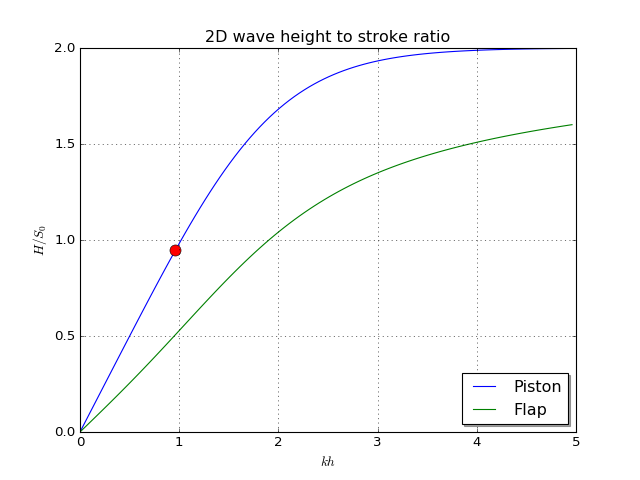

In [8]:
# COMPUTE UNKNOWNS AND CHECK IN THE H/S RATIO CURVES
# ==================================================

# Compute unknowns
Type, S, h, H, a, lamda, k, T, omega, psi, OK = compute_wavemaker_parameters(Type = wavemaker_type, S = S, h = h, H = H, a= a, lamda = lamda, k = k, T = T, omega = omega, psi = psi, print_results = True)

# Plot 2D wave height to stroke ratio
x = np.arange(0.01, 5, 0.05)
y_piston = (4*np.sinh(x)**2)/(np.sinh(2*x)+2*x)
y_flap = (4*np.sinh(x))/(np.sinh(2*x)+2*x)*(np.sinh(x) + (1-np.cosh(x))/x)

fig, ax = plt.subplots()
ax.plot(x, y_piston, label='Piston')
ax.plot(x, y_flap, label='Flap')
ax.plot(k*h, H/S,marker='o', markersize=10, color="red")
ax.set(xlabel=r'$kh$', ylabel=r'$H/S_0$', title='2D wave height to stroke ratio')
legend = ax.legend(loc='lower right', shadow=True)
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


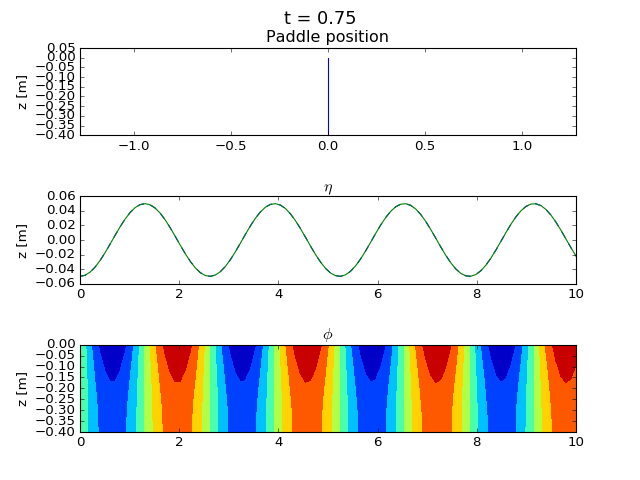

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [9]:
# FREE SURFACE AND FLOW FIELD OF THE LINEAR WAVEMAKER PROBLEM
# ===========================================================

#---------------------------------------------------------------------  
# Note:
# -----
# Tune plot options:
# choose beteen an animation in time or an specific time

ANIMATION = False

if ANIMATION:
    time_steps = 20
    anim_loop = False
else:
    t = t
#---------------------------------------------------------------------

sigma = omega

eta1_wm = np.zeros((X.size,1))
eta1_wm_far = np.zeros((X.size,1))
phi1_wm= np.zeros((X.size,Z.size))

fig, ax = plt.subplots(3)
if ANIMATION: 
    def animate(t):
        t = T*t/time_steps
        for count_x, x in enumerate(X):
            eta1_wm[count_x] = eta1(x,t)
            eta1_wm_far[count_x] = eta1_far(x,t)
            for count_z, z in enumerate(Z):
                phi1_wm[count_x][count_z] = phi1(x,z,t)

        if t is not 0:
            for i in np.arange(0,3,1): ax[i].clear()

        fig.suptitle('t = ' + str(t), fontsize=16)

        if Type == 'piston':
            ax[0].plot([X01(t), X01(t)], [Z[-1], Z[0]])
        elif Type == 'flap':
            ax[0].plot([X01(t), 0], [Z[-1], Z[0]])
        ax[0].set(ylabel='z [m]',title=r'Paddle position', xlim=(-S,S))
        ax[0].axis('equal')
        ax[1].plot(X, eta1_wm_far,'--')
        ax[1].plot(X, eta1_wm)    
        ax[1].set(ylabel='z [m]',title=r'$\eta$', xlim=(0,Lx))
        ax[2].contourf(XX, ZZ, phi1_wm.transpose())
        ax[2].set(ylabel='z [m]',title=r'$\phi$')
        plt.subplots_adjust(hspace=0.7)  
        return ax

    ani = FuncAnimation(fig,animate,frames = time_steps,interval=(T/time_steps)*1000, blit=False, repeat = anim_loop)
    plt.show()
else:
    for count_x, x in enumerate(X):
        eta1_wm[count_x] = eta1(x,t)
        eta1_wm_far[count_x] = eta1_far(x,t)
        for count_z, z in enumerate(Z):
            phi1_wm[count_x][count_z] = phi1(x,z,t)

    if t is not 0:
        for i in np.arange(0,3,1): ax[i].clear()

    fig.suptitle('t = ' + str(t), fontsize=16)

    if Type == 'piston':
        ax[0].plot([X01(t), X01(t)], [Z[-1], Z[0]])
    elif Type == 'flap':
        ax[0].plot([X01(t), 0], [Z[-1], Z[0]])
    ax[0].set(ylabel='z [m]',title=r'Paddle position', xlim=(-S,S))
    ax[0].axis('equal')
    ax[1].plot(X, eta1_wm_far,'--')
    ax[1].plot(X, eta1_wm)    
    ax[1].set(ylabel='z [m]',title=r'$\eta$', xlim=(0,Lx))
    ax[2].contourf(XX, ZZ, phi1_wm.transpose())
    ax[2].set(ylabel='z [m]',title=r'$\phi$')
    plt.subplots_adjust(hspace=0.7)
    plt.show()